In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# This library is used to do hyperparameter search
import skopt
import warnings
warnings.filterwarnings('ignore')


**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [2]:
torch.cuda.is_available()


False

cpu
Files already downloaded and verified
Files already downloaded and verified


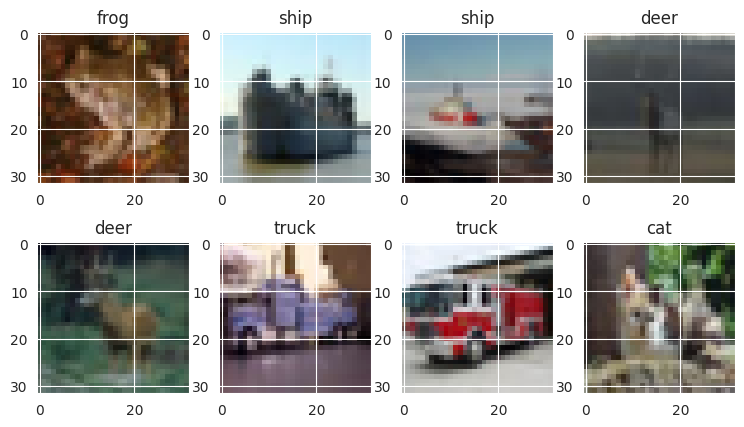

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 1024

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

test_set, val_set = random_split(test_set, [5000, 5000])

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [4]:
class CNN(nn.Module):
    def __init__(self, conv1_hidden, conv1_kernel, pool_kernel, pool_stride, conv2_hidden, linear_output):
        super().__init__()
        self.conv1 = nn.Conv2d(3, conv1_hidden, conv1_kernel)
        self.pool = nn.MaxPool2d(pool_kernel, pool_stride)
        self.conv2 = nn.Conv2d(conv1_hidden, conv2_hidden, conv1_kernel)
        self.fc1 = nn.LazyLinear(linear_output)
        self.fc2 = nn.Linear(linear_output, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def validate_model(model, validation_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Do not calculate gradients to save memory
        for data in validation_loader:
            # Unpack data
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss
            total_loss += loss.item()

    # Calculate average loss
    avg_loss = total_loss / len(validation_loader)

    return avg_loss

hyperparams_space = [
    skopt.space.Integer(16, 64, name='conv1_hidden'),
    skopt.space.Integer(3, 5, name='conv1_kernel'),
    skopt.space.Integer(16, 64, name='conv2_hidden'),
    skopt.space.Integer(64, 256, name='linear_output'),
    ]

@skopt.utils.use_named_args(hyperparams_space)
def objective(**params):
    cnn = CNN(params['conv1_hidden'], params['conv1_kernel'], 2, 2, params['conv2_hidden'], params['linear_output']).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

    patience = 5
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    early_stopping = False
    
    for epoch in range(10):  # loop over the dataset multiple times
        if early_stopping:
            break
            
        for data in train_loader:
            images_train, labels_train = data
            images_train = images_train.to(device)
            labels_train = labels_train.to(device) 
            
            # zero the parameter gradients
            optimizer_cnn.zero_grad()
            
            # forward + backward + optimize
            outputs = cnn(images_train)
            loss = criterion(outputs, labels_train)
            loss.backward()
            optimizer_cnn.step()

            # Check early stopping condition
            if loss < best_loss:
                best_val_loss = loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    early_stopping = True
                    break
        
        scheduler.step()
    
    val_loss = validate_model(cnn, val_loader, criterion)
    print("Validation loss: {}".format(val_loss))
    print(params)
    return val_loss

res_gp = skopt.gp_minimize(objective, hyperparams_space, n_calls=50, random_state=0)
print("Best parameters: {}".format(res_gp.x))


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.6213267683982848
{'conv1_hidden': 44, 'conv1_kernel': 5, 'conv2_hidden': 57, 'linear_output': 227}
Validation loss: 1.6586853861808777
{'conv1_hidden': 46, 'conv1_kernel': 4, 'conv2_hidden': 30, 'linear_output': 75}
Validation loss: 1.1287389993667603
{'conv1_hidden': 29, 'conv1_kernel': 4, 'conv2_hidden': 55, 'linear_output': 156}
Validation loss: 1.4039445757865905
{'conv1_hidden': 35, 'conv1_kernel': 5, 'conv2_hidden': 32, 'linear_output': 188}
Validation loss: 2.302658772468567
{'conv1_hidden': 34, 'conv1_kernel': 5, 'conv2_hidden': 23, 'linear_output': 231}
Validation loss: 2.302666974067688
{'conv1_hidden': 39, 'conv1_kernel': 5, 'conv2_hidden': 41, 'linear_output': 194}
Validation loss: 2.3027061223983765
{'conv1_hidden': 51, 'conv1_kernel': 4, 'conv2_hidden': 42, 'linear_output': 210}
Validation loss: 1.4030404090881348
{'conv1_hidden': 21, 'conv1_kernel': 4, 'conv2_hidden': 25, 'linear_output': 205}
Validation loss: 1.095168900489807
{'conv1_hidden': 26, 'co

/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1325192332267762
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 33, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.2140167951583862
{'conv1_hidden': 35, 'conv1_kernel': 4, 'conv2_hidden': 32, 'linear_output': 78}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.02826526761055
{'conv1_hidden': 17, 'conv1_kernel': 3, 'conv2_hidden': 54, 'linear_output': 72}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.2957205533981324
{'conv1_hidden': 64, 'conv1_kernel': 5, 'conv2_hidden': 52, 'linear_output': 246}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 2.3028607606887816
{'conv1_hidden': 62, 'conv1_kernel': 5, 'conv2_hidden': 54, 'linear_output': 65}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.951554024219513
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 54, 'linear_output': 102}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1795791506767273
{'conv1_hidden': 16, 'conv1_kernel': 5, 'conv2_hidden': 52, 'linear_output': 256}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.2446160197257996
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 54, 'linear_output': 119}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.023657101392746
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 30, 'linear_output': 90}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0059483349323273
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 30, 'linear_output': 167}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.005856317281723
{'conv1_hidden': 16, 'conv1_kernel': 4, 'conv2_hidden': 29, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1397406935691834
{'conv1_hidden': 16, 'conv1_kernel': 5, 'conv2_hidden': 57, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.3990220069885253
{'conv1_hidden': 16, 'conv1_kernel': 5, 'conv2_hidden': 29, 'linear_output': 140}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.6197941660881043
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 64, 'linear_output': 256}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9993504345417022
{'conv1_hidden': 24, 'conv1_kernel': 3, 'conv2_hidden': 31, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9812610566616058
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 29, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9934056282043457
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 28, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.039407992362976
{'conv1_hidden': 20, 'conv1_kernel': 3, 'conv2_hidden': 29, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.075585699081421
{'conv1_hidden': 16, 'conv1_kernel': 5, 'conv2_hidden': 53, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9857997477054596
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 27, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9667059481143951
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 26, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0697772264480592
{'conv1_hidden': 24, 'conv1_kernel': 3, 'conv2_hidden': 55, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0977003574371338
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 16, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9654583096504211
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 54, 'linear_output': 97}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0076489865779876
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 24, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.184568464756012
{'conv1_hidden': 25, 'conv1_kernel': 4, 'conv2_hidden': 28, 'linear_output': 174}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1204774856567383
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 51, 'linear_output': 100}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0177845776081085
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 56, 'linear_output': 100}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.0071798145771027
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 31, 'linear_output': 179}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9779369950294494
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 27, 'linear_output': 77}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 2.302691125869751
{'conv1_hidden': 21, 'conv1_kernel': 3, 'conv2_hidden': 54, 'linear_output': 95}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1142078399658204
{'conv1_hidden': 18, 'conv1_kernel': 3, 'conv2_hidden': 64, 'linear_output': 83}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9888500094413757
{'conv1_hidden': 24, 'conv1_kernel': 3, 'conv2_hidden': 29, 'linear_output': 86}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1007236123085022
{'conv1_hidden': 24, 'conv1_kernel': 3, 'conv2_hidden': 27, 'linear_output': 104}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9741563439369202
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 56, 'linear_output': 70}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1003891944885253
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 30, 'linear_output': 72}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.4232625722885133
{'conv1_hidden': 24, 'conv1_kernel': 3, 'conv2_hidden': 34, 'linear_output': 75}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.2154250621795655
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 59, 'linear_output': 64}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 1.1645758390426635
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 17, 'linear_output': 124}


/home/vini/.cache/pypoetry/virtualenvs/ml-q49JP6Ex-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Validation loss: 0.9830262839794159
{'conv1_hidden': 16, 'conv1_kernel': 3, 'conv2_hidden': 49, 'linear_output': 64}
Best parameters: [18, 3, 54, 102]


In [8]:
res_gp.x

[18, 3, 54, 102]

In [9]:
# Test the model
cnn = CNN(res_gp.x[0], res_gp.x[1], 2, 2, res_gp.x[2], res_gp.x[3]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0

    for data in train_loader:
        images_train, labels_train = data
        images_train = images_train.to(device)
        labels_train = labels_train.to(device)

        # zero the parameter gradients
        optimizer_cnn.zero_grad()

        # forward + backward + optimize
        outputs = cnn(images_train)
        loss = criterion(outputs, labels_train)
        loss.backward()
        optimizer_cnn.step()


        aux += 1

    scheduler.step()
    
val_loss = validate_model(cnn, test_loader, criterion)
print("Validation loss: {}".format(val_loss))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Validation loss: 1.0004797160625458
Accuracy of the network on the 10000 test images: 65 %


# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que 
1) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e 
2) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

**Resposta 1**
Primeiro, podemos escrever uma convolução como $$S(t)=(x*w)(t)=\sum_ax(a)w(t-a)$$ 
 

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Seja também $X = [x_1, \ldots, x_n]^\intercal$ a matriz de features dos nós.

Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j \sum_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existe uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: _graph neural networks_ (GNNs). A mais famosa dessas redes é chamada [_graph convolutional network_ (GCN)](https://arxiv.org/abs/1609.02907). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disso, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

**Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo a $G=(X, A)$.**

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

(Dica: Mostre antes que se $P$ é uma matriz de permutação, então $P^\intercal P = I$.)

**Resposta:** Primeiro, começamos mostrando que para toda matriz de permutação $P$, temos que $P^\intercal P = I$. P é uma matriz ortogonal, visto que suas colunas são ortonormais. Assim, $P^\intercal P = I$.

$\tilde A'=(D')^{-1/2}(PAP^T+I)(D')^{-1/2}$, onde $D'=PDP^T$, visto que $D_{ii}$ representa o grau do nó i, então D também sofre as permutações, logo
$$\tilde A '=PD^{-1/2}P^T(PAP^T+I)PD^{-1/2}P^T$$
$$\tilde A'=PD^{-1/2}AD^{-1/2}P^T+PDP^T$$
$$\tilde A '=PD^{-1/2}(A+I)D^{-1/2}P^T$$
$$\tilde A' = P\tilde A P^T$$

Usaremos esse resultado para calcular qual é os valores das matrizes $H$ dadas as permutações em $\tilde A$
$$H^{(1)}'= \textrm{ReLU}(P\tilde A P^TPXW)$$
$$H^{(1)}'= \textrm{ReLU}(P\tilde AXW)$$
$$H^{(1)}'=PH^{(1)}$$
$$H^{(2)}'=\textrm{ReLU}(P\tilde AP^TPH^{(1)}W)$$
$$H^{(2)}'=\textrm{ReLU}(P\tilde AH^{(1)}W)$$
$$H^{(2)}'=PH^{(2)}$$
$$\vdots$$
$$H^{(\ell)}'=\textrm{ReLU}(P\tilde AP^TPH^{(\ell-1)})W$$
$$H^{(\ell)}'=\textrm{ReLU}(P\tilde AH^{(\ell-1)}W)$$
$$H^{(\ell)}'=PH^{(\ell)}$$

com isso podemos calcular o valor de $\hat y'$
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^n\left(PH^{(L)}\right)_{i:}\right)$$
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^n\sum_{j=1}^nP_{ij}H^{(L)}_{i:}\right)$$
como $P_{ij}$ é 1 pra somente um valor de j e zero para o resto temos:
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^nH^{(L)}_{i:}\right)$$
